In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Hyperparameters & load IMDB (built-in, integer encoded)
MAX_WORDS = 20000      # top-N words to keep
MAX_LEN   = 200        # max tokens per review (pad/truncate)
EMBED_DIM = 128
BATCH     = 128
EPOCHS    = 10

# Load (pre-tokenized integer sequences)
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=MAX_WORDS)
print("Training samples:", len(x_train), "Test samples:", len(x_test))


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000 Test samples: 25000


In [3]:
# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=MAX_LEN, padding='post', truncating='post')
print("x_train shape:", x_train.shape)


x_train shape: (25000, 200)


In [4]:
# Build a Bidirectional LSTM model
def make_birnn_model(max_words=MAX_WORDS, embed_dim=EMBED_DIM, max_len=MAX_LEN):
    model = keras.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=embed_dim, input_length=max_len, name="embedding"),
        # Bidirectional wrapper around an LSTM (you can use GRU similarly)
        layers.Bidirectional(layers.LSTM(64, return_sequences=False), name="bilstm_1"),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')   # binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = make_birnn_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
#  Callbacks and training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_birnn_imdb.h5', save_best_only=True)
]

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks
)


Epoch 1/10
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5841 - loss: 0.6461

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5862 - loss: 0.6444 - val_accuracy: 0.8182 - val_loss: 0.4088
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8899 - loss: 0.2944

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8899 - loss: 0.2944 - val_accuracy: 0.8646 - val_loss: 0.3302
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9382 - loss: 0.1858 - val_accuracy: 0.8614 - val_loss: 0.3439
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9560 - loss: 0.1346 - val_accuracy: 0.8464 - val_loss: 0.4076
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9670 - loss: 0.1002 - val_accuracy: 0.8518 - val_loss: 0.5205


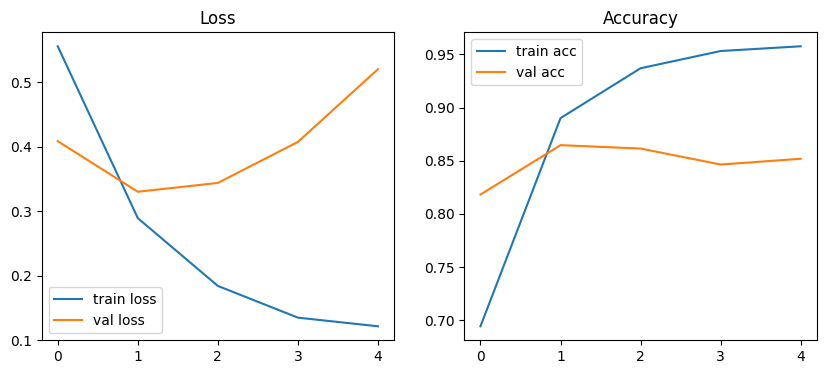

In [6]:
#  Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [7]:
#  Evaluate + classification report
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", loss, "Test accuracy:", acc)

y_proba = model.predict(x_test, batch_size=256)
y_pred = (y_proba > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred, digits=4))


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8416 - loss: 0.3685
Test loss: 0.3743157684803009 Test accuracy: 0.8389599919319153
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0     0.8262    0.8585    0.8420     12500
           1     0.8527    0.8194    0.8358     12500

    accuracy                         0.8390     25000
   macro avg     0.8395    0.8390    0.8389     25000
weighted avg     0.8395    0.8390    0.8389     25000



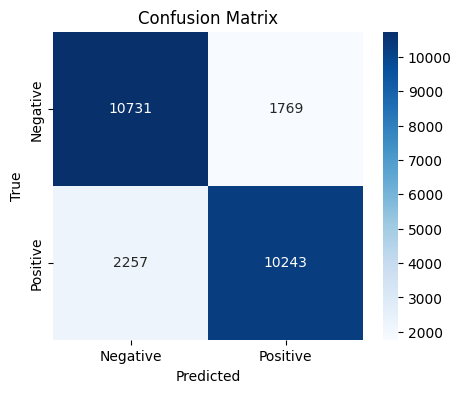

In [8]:
#  Confusion Matrix (with heatmap)
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


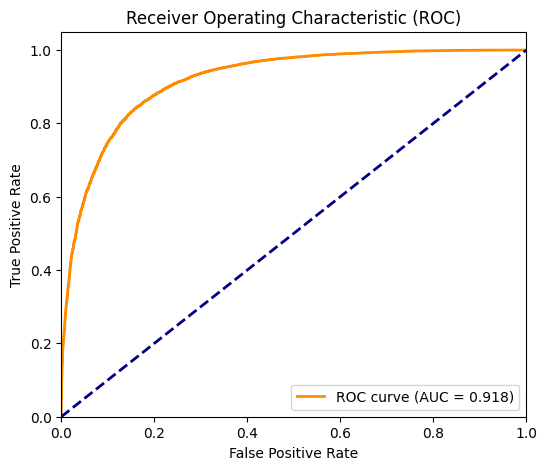

In [9]:
# ROC Curve + AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


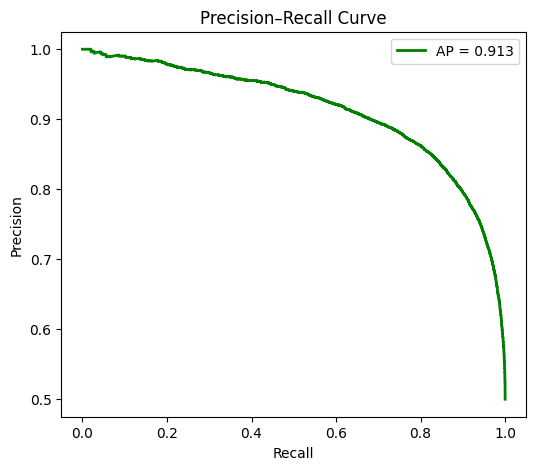

In [10]:
# Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2,
         label=f'AP = {avg_prec:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


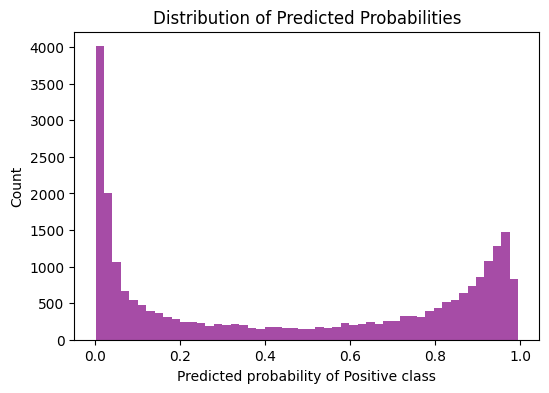

In [11]:
#  Distribution of predicted probabilities
plt.figure(figsize=(6,4))
plt.hist(y_proba, bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted probability of Positive class")
plt.ylabel("Count")
plt.show()


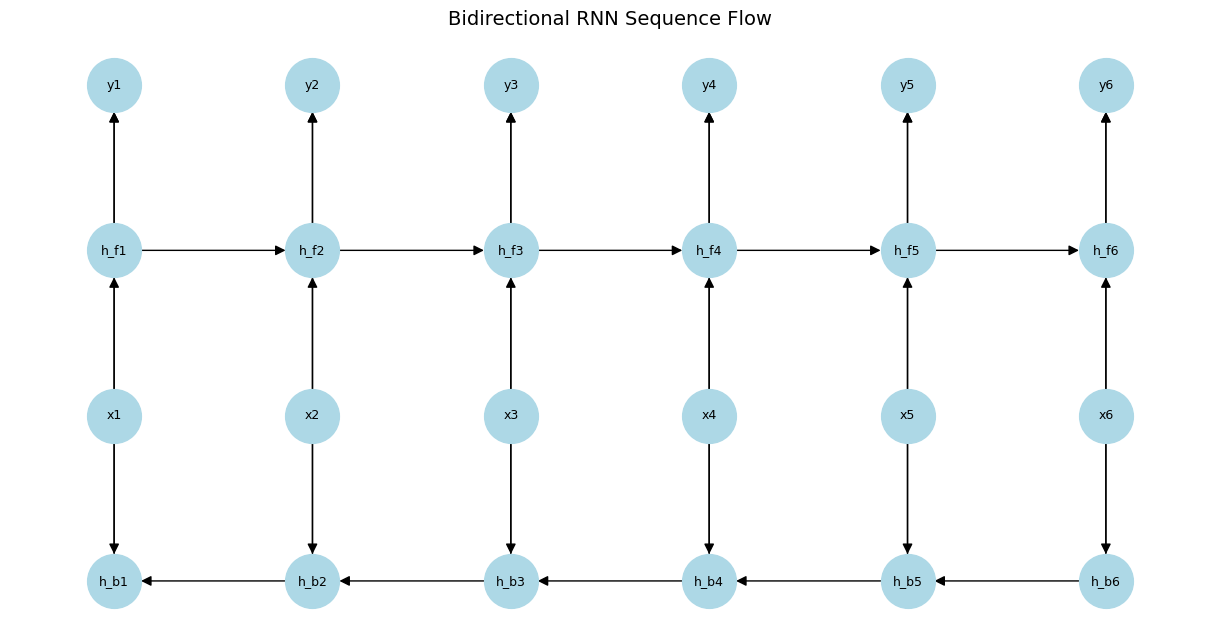

In [12]:
#  Plot Bidirectional RNN sequence flow
import matplotlib.pyplot as plt
import networkx as nx

# Sequence length
timesteps = 6

# Create directed graph
G = nx.DiGraph()

# Add forward hidden states (h1..hn)
for t in range(timesteps):
    G.add_node(f"h_f{t+1}", pos=(t, 1), layer='forward')

# Add backward hidden states (h̄1..h̄n)
for t in range(timesteps):
    G.add_node(f"h_b{t+1}", pos=(t, -1), layer='backward')

# Add input nodes
for t in range(timesteps):
    G.add_node(f"x{t+1}", pos=(t, 0), layer='input')

# Edges: forward direction
for t in range(timesteps-1):
    G.add_edge(f"h_f{t+1}", f"h_f{t+2}")

# Edges: backward direction
for t in range(timesteps-1, 0, -1):
    G.add_edge(f"h_b{t+1}", f"h_b{t}")

# Edges: inputs to both directions
for t in range(timesteps):
    G.add_edge(f"x{t+1}", f"h_f{t+1}")
    G.add_edge(f"x{t+1}", f"h_b{t+1}")

# Combine forward+backward hidden states -> output yt
for t in range(timesteps):
    G.add_node(f"y{t+1}", pos=(t, 2))
    G.add_edge(f"h_f{t+1}", f"y{t+1}")
    G.add_edge(f"h_b{t+1}", f"y{t+1}")

# Draw
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(12,6))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", arrowsize=15, font_size=9)
plt.title("Bidirectional RNN Sequence Flow", fontsize=14)
plt.axis("off")
plt.show()
